# <center> Валидация данных
## <center> Классификация воды
<center> <img src="https://lms.skillfactory.ru/assets/courseware/v1/1551ecc52035a26104579a2b85609940/asset-v1:SkillFactory+DSPR-2.0+14JULY2021+type@asset+block/dst3-ml5-2_3.jpg" width="400" height="250">

### Валидация данных. Методы валидации
- HOLD-OUT
- K-FOLD
- LEAVE-ONE-OUT

### Дисбаланс выборки
- СТРАТИФИЦИРОВАННОЕ РАЗБИЕНИЕ
- ВЫБОР МЕТРИК В УСЛОВИЯХ ДИСБАЛАНСА КЛАССОВ
- ПОСТРОЕНИЕ МОДЕЛИ В УСЛОВИЯХ ДИСБАЛАНСА КЛАССОВ
- ВЫБОР ПОРОГА ВЕРОЯТНОСТИ. PR-КРИВАЯ
- СЭМПЛИРОВАНИЕ

### Недообучение и переобучение
- КАК ОБНАРУЖИТЬ ПЕРЕОБУЧЕНИЕ
- МЕТОДЫ БОРЬБЫ С ПЕРЕОБУЧЕНИЕМ
- УТЕЧКА ДАННЫХ
- КРИВАЯ ОБУЧЕНИЯ

In [128]:
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации
 
from sklearn import metrics #метрики
from sklearn import model_selection #методы разделения и валидации
from sklearn import linear_model #линейные модели
from sklearn import tree #деревья решений
plt.style.use('seaborn') #стиль отрисовки seaborn
%matplotlib inline

In [129]:
water_data = pd.read_csv('/home/mike/Documents/Coding/Data/water_potability.csv')
water_data.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


видно, что большинство столбцов таблицы являются числовыми. Целевой признак — Potability (пригодность для питья): 1 — вода пригодна, 0 — вода не пригодна.

В данных есть пропуски. Выведем информацию о них в процентном соотношении:

In [130]:
display(water_data.isnull().mean() * 100)

ph                 14.987790
Hardness            0.000000
Solids              0.000000
Chloramines         0.000000
Sulfate            23.840049
Conductivity        0.000000
Organic_carbon      0.000000
Trihalomethanes     4.945055
Turbidity           0.000000
Potability          0.000000
dtype: float64

Итак, у нас отсутствует около 15 % информации о кислотности воды (ph), около 24 % — о содержании сульфатов (Sulfate) и около 5 % — о тригалометанах (Trihalomethanes). Мы знаем, что пропуски — непосильная ноша для большинства моделей машинного обучения. Их необходимо обработать.

Заполним пропуски медианным значением в признаке зависимости класса воды (Potability). Для этого сгруппируем данные по признаку Potability, посчитаем медиану в каждой группе, а затем отправим результат в метод fillna():

In [131]:
#Заполняем пропуски
water_data['ph'] = water_data['ph'].fillna(water_data.groupby('Potability')['ph'].transform('median'))
water_data['Sulfate'] = water_data['Sulfate'].fillna(water_data.groupby('Potability')['Sulfate'].transform('median'))
water_data['Trihalomethanes'] = water_data['Trihalomethanes'].fillna(water_data.groupby('Potability')['Trihalomethanes'].transform('median'))

In [132]:
# Убедимся в отсутствии пропусков:

display(water_data.isnull().mean() * 100)

ph                 0.0
Hardness           0.0
Solids             0.0
Chloramines        0.0
Sulfate            0.0
Conductivity       0.0
Organic_carbon     0.0
Trihalomethanes    0.0
Turbidity          0.0
Potability         0.0
dtype: float64

Теперь проблема пропусков устранена. Давайте по традиции разделим набор данных на матрицу наблюдений X и вектор правильных ответов y:

In [133]:
X = water_data.drop('Potability', axis=1)
y = water_data['Potability']

## HOLD-OUT

In [134]:
# Для примера разделим выборку в соотношении 80/20 (test_size=0.2), в качестве значения параметра random_state по традиции возьмём число 42.

X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, test_size=0.2, random_state=42)


In [135]:
# Проверим размеры полученных выборок:

print('Train shape: {}'.format(X_train.shape))
print('Valid shape: {}'.format(X_valid.shape))

Train shape: (2620, 9)
Valid shape: (656, 9)


Итак, 2 620 образцов воды являются обучающими — в них модель будет искать закономерности и подбирать внутренние параметры, а 656 являются валидационными — на них мы будем производить контроль качества.

Далее нам останется только обучить модель на тренировочной выборке (X_train, y_train) и рассчитать метрики на валидационной выборке (X_valid, y_valid).

В качестве модели будем использовать дерево решений с максимальной глубиной 7, энтропией в качестве критерия информативности, минимальное число объектов в листе дерева — 5.

После обучения сделаем предсказание для каждой из выборок и рассчитаем метрику. В качестве метрики для простоты возьмём долю правильных ответов — accuracy.

In [136]:
#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #максимальная глубина
    min_samples_leaf=5, #минимальное число объектов в листе
    random_state=42 #генератор случайных чисел  
)
#Обучаем модель на тренировочной выборке
model.fit(X_train, y_train)
#Делаем предсказание для каждой из выборок
y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_valid)
#Выводим значения метрик
print('Train hold-out accuracy: {:.2f}'.format(metrics.accuracy_score(y_train, y_train_pred)))
print('Valid hold-out accuracy: {:.2f}'.format(metrics.accuracy_score(y_valid, y_valid_pred))) 

Train hold-out accuracy: 0.82
Valid hold-out accuracy: 0.77


Если же мы используем трёхкомпонентный подход (разбиваем выборку на тренировочную, валидационную и отдельную тестовую), тут нам понадобится чуть больше кода. К сожалению, в sklearn нет специализированного функционала для такого разбиения.

Применим функцию train_test_split() дважды: сначала разобьём исходный набор на тренировочный и валидационный в соотношении 80/20, затем разобьём валидационный набор на валидационный и тестовый в соотношении 50/50. В итоге наша выборка будет разбита в соотношении 80/10/10:

In [137]:
#разбиваем исходную выборку на тренировочную и валидационную в соотношении 80/20
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, test_size=0.2, random_state=42)
#разбиваем валидационную выборку на валидационную и тестовую в соотношении 50/50
X_valid, X_test, y_valid, y_test = model_selection.train_test_split(X_valid, y_valid, test_size=0.5, random_state=42)

In [138]:
# Выводим размерности:

print('Train shape: {}'.format(X_train.shape))
print('Valid shape: {}'.format(X_valid.shape))
print('Test shape: {}'.format(X_test.shape))

Train shape: (2620, 9)
Valid shape: (328, 9)
Test shape: (328, 9)


В этом  случае мы будем обучаться на 2 620 примерах, 328 будем использовать для промежуточного контроля и подбора внешних параметров и ещё 328 будут нашим контрольным рубежом — их мы будем использовать для принятия финального решения о качестве модели.

## K-FOLD

У объекта класса KFold есть метод split(). В данный метод необходимо передать матрицу наблюдений X и вектор-столбец ответов y — метод вернёт генератор, который позволит получать индексы тренировочной и валидационной выборок, сгенерированных по методу k-fold.

Будем использовать двухкомпонентный контроль, то есть подавать в кросс-валидацию весь доступный набор данных без предварительного выделения тестовой выборки.

Создадим объект KFold для кросс-валидации с пятью фолдами, остальные параметры оставим по умолчанию. Затем организуем цикл for для получения элементов из генератора, созданного с помощью метода split(). На каждой итерации в переменных train_index и valid_index будут находиться индексы текущей тренировочной и валидационной выборок соответственно.

В цикле будем:

- выделять строки таблицы, относящиеся к текущим тренировочной и валидационной выборкам, в отдельные таблицы;
- обучать дерево решений;
- делать предсказания для текущих тренировочной и валидационной выборок;
- рассчитывать метрику accuracy на текущих выборках и заносить её значение в список.

Код будет выглядеть следующим образом:

In [139]:
#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #максимальная глубина
    min_samples_leaf=5, #минимальное число объектов в листе
    random_state=42 #генератор случайных чисел  
)
 
#Создаём объект кросс-валидатора KFold
kf = model_selection.KFold(n_splits=5)
#Создаём список для хранения тренировочных и валидационных метрик
train_metrics = []
val_metrics = []
#Организуем цикл для кросс-валидации (используем весь набор данных)
#train_index — индексы тренировочной выборки
#valid_index — индексы валидационной выборки
for train_index, valid_index in kf.split(X, y): 
    #Создаём тренировочную и валидационную выборку, обращаясь по текущим индексам
    X_train, y_train = X.iloc[train_index], y.iloc[train_index]
    X_valid, y_valid = X.iloc[valid_index], y.iloc[valid_index]
    #Обучаем случайный лес на тренировочной выборке
    model.fit(X_train, y_train)
    #Делаем предсказание для каждой из выборок
    y_train_pred = model.predict(X_train)
    y_valid_pred = model.predict(X_valid)
    #Рассчитываем метрику и заносим её в список
    train_metrics.append(metrics.accuracy_score(y_train, y_train_pred))
    val_metrics.append(metrics.accuracy_score(y_valid, y_valid_pred))

In [140]:
# Выведем содержимое массивов train_metrics и val_metrics:

print(train_metrics)
print(val_metrics)

[0.8034351145038168, 0.8168637924456315, 0.8027470431133156, 0.8267836703548264, 0.8157191911484166]
[0.7957317073170732, 0.7053435114503817, 0.7358778625954199, 0.7282442748091603, 0.732824427480916]


В каждом из выведенных списков содержится по пять значений метрики accuracy, вычисленных на тренировочном и валидационном фолдах кросс-валидации. Для агрегированной оценки рассчитаем среднее значение метрик:

In [141]:
print('Train k-fold mean accuracy: {:.2f}'.format(np.mean(train_metrics)))
print('Valid k-fold mean accuracy: {:.2f}'.format(np.mean(val_metrics)))

Train k-fold mean accuracy: 0.81
Valid k-fold mean accuracy: 0.74


### функция cross_validate()

Основные параметры функции cross_validate():

- estimator — модель, качество которой будет проверяться на кросс-валидации.
- X — матрица наблюдений.
- y — вектор-столбец правильных ответов.
- cv — кросс-валидатор из библиотеки sklearn (например, KFold) или количество фолдов, на которые необходимо разбить выборку. По умолчанию используется кросс-валидация на пяти фолдах.
- scoring — название метрики в виде строки либо функция для её вычисления ('accuracy', 'precision', 'recall', 'f1' и другие; полный список — в документации к функции).
- return_train_score — параметр, указывающий стоит ли возвращать значения метрики, полученных на тренировочных фолдах. По умолчанию — False, то есть метрики считаются только на валидационных фолдах.

Функция возвращает словарь со следующими ключами:

- fit_time — время обучения модели на каждой итерации кросс-валидации;
- score_time — время вычисления метрик на каждой итерации кросс-валидации;
- test_score — значения метрик на валидационных фолдах;
- train_score — значения метрик на тренировочных фолдах.

Итоговый код с использованием функции cross_validate() будет выглядеть следующим образом:

In [142]:
#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #максимальная глубина
    min_samples_leaf=5, #минимальное число объектов в листе
    random_state=42 #генератор случайных чисел  
)
 
#Создаём объект кросс-валидатора KFold
kf = model_selection.KFold(n_splits=5)
 
#Считаем метрики на кросс-валидации k-fold
cv_metrics = model_selection.cross_validate(
    estimator=model, #модель
    X=X, #матрица наблюдений X
    y=y, #вектор ответов y
    cv=kf, #кросс-валидатор
    scoring='accuracy', #метрика
    return_train_score=True #подсчёт метрики на тренировочных фолдах
)
display(cv_metrics)

{'fit_time': array([0.03390694, 0.03465009, 0.03577924, 0.03221154, 0.03269243]),
 'score_time': array([0.00264215, 0.00226545, 0.00226426, 0.00261641, 0.00247478]),
 'test_score': array([0.79573171, 0.70534351, 0.73587786, 0.72824427, 0.73282443]),
 'train_score': array([0.80343511, 0.81686379, 0.80274704, 0.82678367, 0.81571919])}

В массивах, хранящихся по ключам train_score и test_score, содержится по пять значений метрики accuracy, полученных на тренировочных и валидационных фолдах соответственно на каждой итерации кросс-валидации. Давайте рассчитаем среднее:

In [143]:
print('Train k-fold mean accuracy: {:.2f}'.format(np.mean(cv_metrics['train_score'])))
print('Valid k-fold mean accuracy: {:.2f}'.format(np.mean(cv_metrics['test_score'])))

Train k-fold mean accuracy: 0.81
Valid k-fold mean accuracy: 0.74


### LEAVE-ONE-OUT

РЕАЛИЗАЦИЯ МЕТОДА В SKLEARN

В библиотеке sklearn метод leave-one-out реализован в классе LeaveOneOut. Параметров инициализации у данного класса нет.

Работа с кросс-валидатором полностью идентична работе с KFold, который мы рассматривали ранее (цикл для организации кросс-валидации вручную будет выглядеть аналогично).

Объект класса LeaveOneOut также можно передать в функцию cross_validate() для получения метрик на каждом из примеров. В случае с метрикой accuracy список будет состоять из 0 и 1 (0 — модель не угадала класс на отложенном примере, 1 — модель угадала класс на отложенном примере).

Так как датасет у нас довольно большой (более трёх тысяч образцов воды), алгоритм кросс-валидации leave-one-out будет выполняться очень долго. Для экономии времени выполнения кода будем использовать первые 500 наблюдений из исходной таблицы.

Примечание. Значение метрики будет рассчитано не для всего набора данных, а только для его части. Если вы захотите рассчитать метрику на всём наборе данных, вместо среза передавайте в функцию таблицу X и столбец y целиком. Но имейте в виду, что код в таком случае может выполняться до нескольких минут.

In [144]:
#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #максимальная глубина
    min_samples_leaf=5, #минимальное число объектов в листе
    random_state=42 #генератор случайных чисел  
)
 
#Создаём кросс-валидатор LeaveOneOut
loo = model_selection.LeaveOneOut()
 
#Считаем метрики на кросс-валидации leave-one-out
cv_metrics = model_selection.cross_validate(
    estimator=model, #модель
    X=X.iloc[:500], #матрица наблюдений X - заданы первые 500 строк
    y=y.iloc[:500], #вектор ответов y - заданы первые 500 строк
    cv=loo, #кросс-валидатор
    scoring='accuracy', #метрика
    return_train_score=True #подсчёт метрики на тренировочных фолдах
)
 
print('Train k-fold mean accuracy: {:.2f}'.format(np.mean(cv_metrics['train_score'])))
print('Valid k-fold mean accuracy: {:.2f}'.format(np.mean(cv_metrics['test_score'])))

Train k-fold mean accuracy: 0.95
Valid k-fold mean accuracy: 0.90


Примечание. Метод leave-one-out можно реализовать и без использования специального класса — достаточно просто указать параметр n_split=n в инициализаторе KFold, где n — количество строк в таблице.

# Дисбаланс выборки

Рассмотрим влияние дисбаланса на примере датасета о качестве воды. Посмотрим на соотношения классов внутри датасета:

0    0.60989
1    0.39011
Name: Potability, dtype: float64

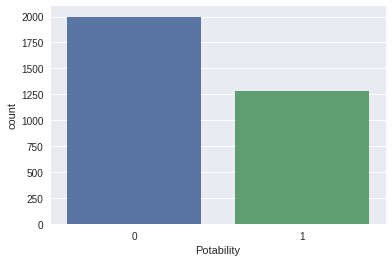

In [145]:
display(water_data['Potability'].value_counts(normalize=True))
sns.countplot(data=water_data, x='Potability');

### СТРАТИФИЦИРОВАННОЕ РАЗБИЕНИЕ

Для того чтобы снизить влияние дисбаланса классов при разбиении выборки, в наборе данных используется специальный тип разбиения, который называется стратифицированным (stratified). Данное разбиение предполагает, что наблюдения, принадлежащие каждому из классов, гарантированно попадут в каждый из наборов данных в одинаковой пропорции.

Давайте на на примере рассмотрим, как производить стратифицированное разбиение. Начнём с простого разделения hold-out, которое мы проводим с помощью функции train_test_split(). Для начала проведём обычное случайное разбиение на тренировочную и валидационную выборку (в соотношении 80/20) без стратификации:

In [146]:
X, y = water_data.drop('Potability', axis=1), water_data['Potability']
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, test_size=0.2, random_state=1)
print('Train:\n', y_train.value_counts(normalize=True), sep='')
print('Valid:\n', y_valid.value_counts(normalize=True), sep='')

Train:
0    0.620229
1    0.379771
Name: Potability, dtype: float64
Valid:
0    0.568598
1    0.431402
Name: Potability, dtype: float64


Мы видим, что соотношения классов в тренировочной выборке — 62/38, а в тестовой — 56/43. Давайте попробуем сбалансировать соотношения.

Для стратифицированного разбиения достаточно в функции train_test_split() задать параметр stratify, в который нужно передать столбец с метками классов, на основе которого будет производиться балансировка. Это будет столбец с правильными ответами y.

In [147]:
X_train, X_valid, y_train, y_valid= model_selection.train_test_split(X, y, stratify=y, test_size=0.2, random_state=1)
print('Train:\n', y_train.value_counts(normalize=True), sep='')
print('Valid:\n', y_test.value_counts(normalize=True), sep='')

Train:
0    0.609924
1    0.390076
Name: Potability, dtype: float64
Valid:
0    0.670732
1    0.329268
Name: Potability, dtype: float64


Для сбалансированной кросс-валидации вместо KFold используется кросс-валидатор StratifiedKFold

Давайте напишем код, который организует стратифицированное k-fold-разбиение на три фолда, и выведем соотношения классов в каждой из выборок:

In [148]:
skf = model_selection.StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
for train_index, valid_index in skf.split(X, y): 
    X_train, y_train = X.iloc[train_index], y.iloc[train_index]
    X_valid, y_valid = X.iloc[valid_index], y.iloc[valid_index]
    print('Train:\n', y_train.value_counts(normalize=True), sep='')
    print('Valid:\n', y_valid.value_counts(normalize=True), sep='')
    print('-'*40)

Train:
0    0.60989
1    0.39011
Name: Potability, dtype: float64
Valid:
0    0.60989
1    0.39011
Name: Potability, dtype: float64
----------------------------------------
Train:
0    0.60989
1    0.39011
Name: Potability, dtype: float64
Valid:
0    0.60989
1    0.39011
Name: Potability, dtype: float64
----------------------------------------
Train:
0    0.60989
1    0.39011
Name: Potability, dtype: float64
Valid:
0    0.60989
1    0.39011
Name: Potability, dtype: float64
----------------------------------------


Видно, что соотношения классов в тренировочной и валидационной выборках в каждом разбиении примерно одинаковы — 61/39.

Так же, как и другие кросс-валидаторы, объект класса StratifiedKFold может быть использован в функции cross_validate().

### Задание 3.3

Ниже представлен код для генерации задачи классификации и отрисовки диаграммы рассеяния с цветовой группировкой по классам

Разбейте исходный набор данных на тренировочный и валидационный со стратификацией по классам в соотношении 80/20. В качестве значения параметра random_state возьмите число 42.

Постройте диаграммы рассеяния с цветовой группировкой по классам для валидационной выборки.

In [149]:
# from sklearn import datasets
# X, y = datasets.make_classification(
#     n_samples=200, #количество объектов
#     n_features=2, #количество признаков
#     n_informative=2, #количество информативных признаков
#     n_redundant=0, #количество неинформативных признаков
#     n_classes=2, #количество классов
#     weights=[1, 0.2], #пропорции классов
#     random_state=40 #генератор случайных чисел
# )
# X = pd.DataFrame(X, columns=['feature_1', 'feature_2'])
# y = pd.Series(y)

# # Ответ
# X_train, X_valid, y_train, y_valid= model_selection.train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# # Визуализация (продолжение исходного кодаЯ)
# sns.scatterplot(x=X_valid['feature_1'], y=X_valid['feature_2'], hue=y);

### ВЫБОР МЕТРИК В УСЛОВИЯХ ДИСБАЛАНСА КЛАССОВ

Разобьём выборку на тренировочную и валидационную в соотношении 80/20, используя стратифицированное разбиение, затем обучим модель дерева решений, сделаем предсказание для каждой из выборок и сформируем отчёт о метриках на валидационной выборке с помощью функции classification_report().

In [150]:
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #максимальная глубина
    min_samples_leaf=5, #минимальное число объектов в листе
    random_state=42, #генератор случайных чисел
)

#Обучаем модель на тренировочной выборке
model.fit(X_train, y_train)

#Делаем предсказание для каждой из выборок
y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_valid)

#Выводим значения метрик
print(metrics.classification_report(y_valid, y_valid_pred)) 

              precision    recall  f1-score   support

           0       0.76      0.92      0.83       400
           1       0.81      0.55      0.65       256

    accuracy                           0.77       656
   macro avg       0.78      0.73      0.74       656
weighted avg       0.78      0.77      0.76       656



Из отчёта о метриках классификации видно, что для валидационной выборки метрика accuracy составляет 0.77, что, в принципе, является довольно хорошим результатом. Однако если мы посмотрим на метрики recall и f1-score для каждого из классов в отдельности, мы увидим, что метрики для класса 0 значительно выше, чем метрики для класса 1.

- Precision для класса 1 составляет 0.81, то есть из всех образцов воды, причисленных моделью к классу пригодных для питья, 81 % действительно являются таковыми.
- Recall для класса 1 составляет 0.55, то есть из всех образцов воды пригодными для питья являются лишь 55 %, при этом остальные 45 % модель посчитала непригодными для питья.
- F1-мера — среднее гармоническое между precision и recall — составила 0.65 для класса 1 и 0.83 — для класса 0. Разница довольно далека от нуля, а значит построенная нами модель больше контролируется на образцах воды, непригодных для питья, и обладает плохой различающей способностью.

Однако мы не смогли бы выявить этот факт, если бы ориентировались только на метрику accuracy. Одной из причин такого результата является дисбаланс классов: образцов непригодной для питья попросту больше, чем пригодных для питья.

### Задание 3.5

Для выполнения этого задания используйте сгенерированные тренировочную и валидационную выборки из задания 3.3.

Обучите модель логистической регрессии на тренировочной выборке (все параметры оставьте по умолчанию).

Сделайте предсказание для валидационной выборки и рассчитайте метрики классификации. Ответ округлите до двух знаков после точки-разделителя.

In [151]:
# # Повторяем задание 3.3

# from sklearn import datasets
# X, y = datasets.make_classification(
#     n_samples=200, #количество объектов
#     n_features=2, #количество признаков
#     n_informative=2, #количество информативных признаков
#     n_redundant=0, #количество неинформативных признаков
#     n_classes=2, #количество классов
#     weights=[1, 0.2], #пропорции классов
#     random_state=40 #генератор случайных чисел
# )

# # Ответ
# X_train, X_valid, y_train, y_valid= model_selection.train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [152]:
# #Создаем объект класса логистическая регрессия
# log_reg_full = linear_model.LogisticRegression()

# #Обучаем модель на тренировочной выборке X_train и y_train
# log_reg_full.fit(X_train, y_train)

# #Делаем предсказание класса и вероятности для валидационной выборки
# y_pred = log_reg_full.predict(X_valid)

# #Выводим значения метрик
# print(metrics.classification_report(y_valid, y_pred)) 

### Задание 3.6 (на самопроверку)

Воспользуйтесь функцией plot_probabilities_2d(), которую мы написали в модуле по классификации, для того, чтобы построить разделяющую поверхность логистической регрессии.

Передайте в её аргументы матрицу наблюдений X, вектор ответов y и обученную в задании 3.5 логистическую регрессию.

In [153]:
def plot_probabilities_2d(X, y, model):
    #Генерируем координатную сетку из всех возможных значений для признаков
    #Glucose изменяется от x1_min = 44 до x2_max = 199, 
    #BMI - от x2_min = 18.2 до x2_max = 67.1
    #Результат работы функции - два массива xx1 и xx2, которые образуют координатную сетку
    xx1, xx2 = np.meshgrid(
        np.arange(X.iloc[:, 0].min()-1, X.iloc[:, 0].max()+1, 0.1),
        np.arange(X.iloc[:, 1].min()-1, X.iloc[:, 1].max()+1, 0.1)
    )
    #Вытягиваем каждый из массивов в вектор-столбец - reshape(-1, 1)
    #Объединяем два столбца в таблицу с помощью hstack
    X_net = np.hstack([xx1.reshape(-1, 1), xx2.reshape(-1, 1)])
    #Предсказывает вероятность для всех точек на координатной сетке
    #Нам нужна только вероятность класса 1
    probs = model.predict_proba(X_net)[:, 1]
    #Переводим столбец из вероятностей в размер координатной сетки
    probs = probs.reshape(xx1.shape)
    #Создаем фигуру и координатную плоскость
    fig, ax = plt.subplots(figsize = (10, 5))
    #Рисуем тепловую карту вероятностей
    contour = ax.contourf(xx1, xx2, probs, 100, cmap='bwr')
    #Рисуем разделяющую плоскость - линия, где вероятность равна 0.5
    bound = ax.contour(xx1, xx2, probs, [0.5], linewidths=2, colors='black');
    #Добавляем цветовую панель 
    colorbar = fig.colorbar(contour)
    #Накладываем поверх тепловой карты диаграмму рассеяния
    sns.scatterplot(x=X.iloc[:, 0], y=X.iloc[:, 1], hue=y, palette='seismic', ax=ax)
    #Даем графику название
    ax.set_title('Scatter Plot with Decision Boundary');
    #Смещаем легену в верхний левый угол вне графика
    ax.legend(bbox_to_anchor=(-0.05, 1))



In [154]:
# X = pd.DataFrame(X)
# y = pd.Series(y)

# # Применяем функцию
# plot_probabilities_2d(X, y, log_reg_full)

## ПОСТРОЕНИЕ МОДЕЛИ В УСЛОВИЯХ ДИСБАЛАНСА КЛАССОВ

### ВЗВЕШИВАНИЕ ОБЪЕКТОВ

Для того чтобы задать веса классам по приведённым выше формулам, достаточно в инициализаторе модели выставить параметр class_weight='balanced'.

Посмотрим на реализацию на примере дерева решений:

In [155]:
#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #максимальная глубина
    min_samples_leaf=5, #минимальное число объектов в листе
    random_state=42, #генератор случайных чисел
    class_weight='balanced' #веса классов
)
#Обучаем модель на тренировочной выборке
model.fit(X_train, y_train)
#Делаем предсказание для каждой из выборок
y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_valid)
#Выводим значения метрик    
print(metrics.classification_report(y_valid, y_valid_pred))

              precision    recall  f1-score   support

           0       0.82      0.71      0.76       400
           1       0.63      0.76      0.69       256

    accuracy                           0.73       656
   macro avg       0.72      0.73      0.72       656
weighted avg       0.74      0.73      0.73       656



### Задание 3.7

Обучите модель логистической регрессии на тренировочной выборке, уставив сбалансированные веса для классов.
Сделайте предсказание для валидационной выборки и рассчитайте метрики классификации.

In [156]:
# from sklearn import datasets
# X, y = datasets.make_classification(
#     n_samples=200, #количество объектов
#     n_features=2, #количество признаков
#     n_informative=2, #количество информативных признаков
#     n_redundant=0, #количество неинформативных признаков
#     n_classes=2, #количество классов
#     weights=[1, 0.2], #пропорции классов
#     random_state=40 #генератор случайных чисел
# )
# log_reg_balanced = linear_model.LogisticRegression(class_weight='balanced')
# log_reg_balanced.fit(X_train, y_train)
# y_valid_pred = log_reg_balanced.predict(X_valid)
# print(metrics.classification_report(y_valid, y_valid_pred))

### Задание 3.8

Воспользуйтесь функцией plot_probabilities_2d(), которую мы написали в модуле по классификации, для того, чтобы построить разделяющую поверхность логистической регрессии со сбалансированными весами классов.

Передайте в её аргументы матрицу наблюдений X, вектор ответов y и обученную в задании 3.7 логистическую регрессию.

In [157]:
# X = pd.DataFrame(X)
# y = pd.Series(y)

# plot_probabilities_2d(X, y, log_reg_balanced)

## ВЫБОР ПОРОГА ВЕРОЯТНОСТИ. PR-КРИВАЯ

PR-кривая (precision-recall curve) — это график зависимости precision от recall при различных значениях порога вероятности.

Перед построением PR-кривой нам необходимо предсказать вероятности принадлежности к классу 1 на валидационных фолдах кросс-валидации.

Для предсказания вероятностей используем функцию cross_val_predict(). Данная функция выполняет кросс-валидацию и возвращает предсказания для валидационных фолдов. Если ей передать параметр method='predict_proba', она вернёт предсказанные вероятности для каждого из классов на всех фолдах. Остальные параметры аналогичны параметрам функции cross_validate():
- estimator — модель, качество которой будет проверяться на кросс-валидации.
- X — матрица наблюдений.
- y — вектор-столбец правильных ответов.
- cv — кросс-валидатор из библиотеки sklearn (например, KFold) или количество фолдов, на которые необходимо разбить выборку. По умолчанию используется кросс-валидация на пяти фолдах.
- scoring — название метрики в виде строки либо функция для её вычисления ('accuracy', 'precision', 'recall', 'f1' и др.).
- return_train_score — параметр, указывающий стоит ли возвращать значения метрики, полученных на тренировочных фолдах. По умолчанию — False, то есть метрики считаются только на валидационных фолдах.


In [158]:
#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #максимальная глубина
    min_samples_leaf=5, #минимальное число объектов в листе
    random_state=42 #генератор случайных чисел 
)
#Обучаем модель
model.fit(X_train, y_train)
#Создаём кросс-валидатор k-fold со стратификацией
skf = model_selection.StratifiedKFold(n_splits=5)
#Делаем предсказание вероятностей на кросс-валидации
y_cv_proba_pred = model_selection.cross_val_predict(model, X_train, y_train, cv=skf, method='predict_proba')

In [159]:
y_cv_proba_pred

array([[0.        , 1.        ],
       [0.24561404, 0.75438596],
       [1.        , 0.        ],
       ...,
       [0.60621762, 0.39378238],
       [1.        , 0.        ],
       [0.03030303, 0.96969697]])

Это массив из вероятностей для каждого образца воды. Первое число в строке — вероятность того, что данный образец является непригодным для питья, а второе — вероятность того, что данный образец пригоден для питья.

Нас интересует класс 1 (пригодная для питья вода). Это второй столбец в матрице вероятностей (индекс 1). Выделим этот столбец из матрицы с вероятностями:

In [160]:
#Выделяем столбец с вероятностями для класса 1 
y_cv_proba_pred = y_cv_proba_pred[:, 1]

In [161]:
#Вычисляем координаты PR-кривой
precision, recall, thresholds = metrics.precision_recall_curve(y_train, y_cv_proba_pred)

print('Thresholds:', thresholds[:5])
print('Precision scores:', precision[:5])
print('Recall scores:',recall[:5])

Thresholds: [0.         0.02739726 0.02898551 0.05       0.07407407]
Precision scores: [0.39007634 0.50050659 0.50357873 0.50437919 0.5043837 ]
Recall scores: [1.         0.9667319  0.96379648 0.95792564 0.95694716]


Best threshold = 0.33, F1-Score = 0.69


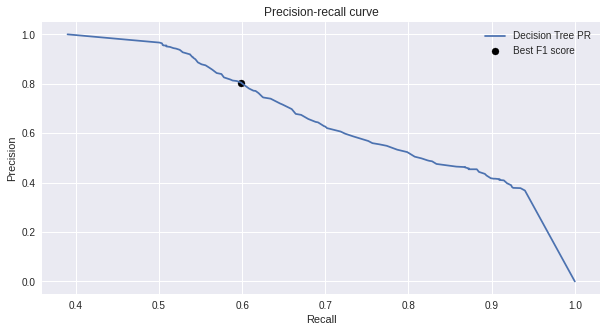

In [162]:
#Вычисляем F1-score при различных threshold
f1_scores = (2 * precision * recall) / (precision + recall)
#Определяем индекс максимума
idx = np.argmax(f1_scores)
print('Best threshold = {:.2f}, F1-Score = {:.2f}'.format(thresholds[idx], f1_scores[idx]))
 
#Строим PR-кривую
fig, ax = plt.subplots(figsize=(10, 5)) #фигура + координатная плоскость
#Строим линейный график зависимости precision от recall
ax.plot(precision, recall, label='Decision Tree PR')
#Отмечаем точку максимума F1
ax.scatter(precision[idx], recall[idx], marker='o', color='black', label='Best F1 score')
#Даём графику название и подписываем оси
ax.set_title('Precision-recall curve')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
#Отображаем легенду
ax.legend();

In [163]:
#Образцы воды, для которых вероятность быть пригодными для питья > threshold_opt, относим к классу 1
#В противном случае — к классу 0
y_valid_pred_proba = model.predict_proba(X_valid)[:, 1]
y_valid_pred = (y_valid_pred_proba > threshold_opt).astype('int')
#Считаем метрики
print(metrics.classification_report(y_valid, y_valid_pred))

NameError: name 'threshold_opt' is not defined

Итак, при применении метода подбора вероятности увеличилось значение метрик recall и  для класса 1. Нам удалось сократить разницу метрик между классами и заставить модель практически одинаково хорошо предсказывать классы питьевой и непитьевой воды.

Примечание. Чтобы вычислить площадь под PR-кривой, используется функция auc() из модуля metrics библиотеки sklearn. В данную функцию нужно передать значения метрик recall и precision при различных порогах вероятности:

In [164]:
print('PR AUC: {:.2f}'.format(metrics.auc(recall, precision)))

PR AUC: 0.79


## СЭМПЛИРОВАНИЕ

Следующий подход работы в условиях дисбаланса классов, который мы рассмотрим, — сэмплирование, а точнее — пересэмплирование (oversampling).

Идея очень проста: если у нас мало наблюдений миноритарного класса, следует искусственно увеличить их количество.

SMOTE (Synthetic Minority Oversampling Techniques).

In [165]:
from imblearn.over_sampling import SMOTE

Создадим объект класса SMOTE и вызовем у него метод fit_sample(), передав в него обучающую выборку (X_train, y_train). Затем выведем количество наблюдений каждого из классов до и после сэмплирования:

In [166]:
X_train = pd.DataFrame(X_train)
y_train = pd.Series(y_train)


sm = SMOTE(random_state=2)
X_train_s, y_train_s = sm.fit_resample(X_train, y_train)

print('Train shape before oversampling:', X_train.shape) 
print('Class balance before oversampling: \n', y_train.value_counts(), sep='')
print('-'*40)
print('Train shape after oversampling:', X_train_s.shape)
print('Class balance after oversampling: \n', y_train_s.value_counts(), sep='')

Train shape before oversampling: (2620, 9)
Class balance before oversampling: 
0    1598
1    1022
Name: Potability, dtype: int64
----------------------------------------
Train shape after oversampling: (3196, 9)
Class balance after oversampling: 
0    1598
1    1598
Name: Potability, dtype: int64


Итак, размер выборки увеличился с 2 620 примеров до 3 196, и теперь количество наблюдений каждого из классов одинаково (1 598/1 598).

Попробуем обучить нашу модель на сгенерированных обучающих данных и сделать предсказание на валидационной выборке (обратите внимание, что с валидационным набором данных мы не производим никаких преобразований), чтобы рассчитать метрики:

In [167]:
#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #максимальная глубина
    min_samples_leaf=5, #минимальное число объектов в листе
    random_state=42, #генератор случайных чисел
)
#Обучаем модель на тренировочной выборке (с сэмплированием)
model.fit(X_train_s, y_train_s)
#Делаем предсказание для каждой из выборок
y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_valid)
#Выводим значения метрик    
print(metrics.classification_report(y_valid, y_valid_pred))

              precision    recall  f1-score   support

           0       0.83      0.70      0.76       400
           1       0.63      0.78      0.69       256

    accuracy                           0.73       656
   macro avg       0.73      0.74      0.73       656
weighted avg       0.75      0.73      0.73       656



### ЗАДАНИЕ 3.11

Сбалансируйте тренировочную выборку с помощью алгоритма SMOTE. В качестве значения параметра random_state возьмите число 42, остальные параметры оставьте по умолчанию.

Обучите модель логистической регрессии на пересэмплированной тренировочной выборке. Все параметры оставьте по умолчанию.

Сделайте предсказание для валидационной выборки и рассчитайте метрики классификации.

In [ ]:
# from sklearn import datasets
# from imblearn.over_sampling import SMOTE
# X, y = datasets.make_classification(
#     n_samples=200, #количество объектов
#     n_features=2, #количество признаков
#     n_informative=2, #количество информативных признаков
#     n_redundant=0, #количество неинформативных признаков
#     n_classes=2, #количество классов
#     weights=[1, 0.2], #пропорции классов
#     random_state=40 #генератор случайных чисел
# )

# sm = SMOTE(random_state=2)
# X_train_s, y_train_s = sm.fit_resample(X_train, y_train)
# log_reg_smote = linear_model.LogisticRegression(class_weight='balanced')
# log_reg_smote.fit(X_train_s, y_train_s)
# y_valid_pred = log_reg_smote.predict(X_valid)
# print(metrics.classification_report(y_valid, y_valid_pred))

              precision    recall  f1-score   support

           0       0.97      0.89      0.93        36
           1       0.43      0.75      0.55         4

    accuracy                           0.88        40
   macro avg       0.70      0.82      0.74        40
weighted avg       0.92      0.88      0.89        40



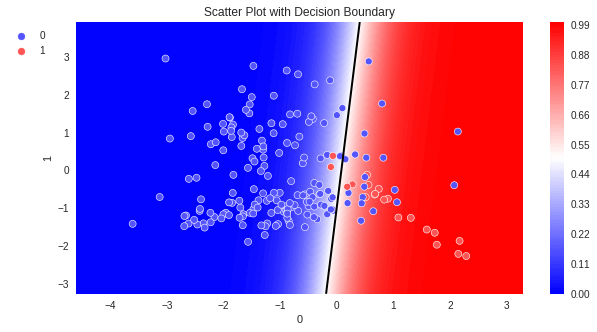

In [ ]:
# X = pd.DataFrame(X)
# y = pd.Series(y)

# plot_probabilities_2d(X, y, log_reg_balanced)

## Недообучение и переобучение

Дилемма смещения-разброса (bias-variance tradeoff)

Смещение (bias) — это математическое ожидание (обозначено как E) разности между истинным ответом и ответом, выданным моделью. То есть это ожидаемая ошибка модели.
Bias — это теоретическая характеристика недообучения.

Разброс (variance) — это вариативность ошибки, то, насколько ошибка будет отличаться, если обучать модель на разных наборах данных. Математически это дисперсия (разброс) ответов модели (обозначено как Var).
Variance — это теоретическая характеристика переобучения


Сначала проверим модель на переобучение с помощью отложенной (hold-out) выборки.

Для этого стратифицированно разобьём набор данных на тренировочную и валидационную выборки в соотношении 80/20 и обучим дерево решений с энтропией  в качестве критерия информативности и сбалансированными весами классов без ограничения его глубины и количества объектов в листе. Сделаем предсказание для каждой из выборок и рассчитаем метрику F1-score:

In [168]:
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
#Создаём модель
model_bad = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    class_weight='balanced', #веса классов
    random_state=42 #генератор случайных чисел
)
#Обучаем модель на тренировочной выборке
model_bad.fit(X_train, y_train)
#Делаем предсказание для каждой из выборок
y_train_pred = model_bad.predict(X_train)
y_valid_pred = model_bad.predict(X_valid)
#Выводим значения метрик для тренировочной выборки
print('Train F1 score: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
#Выводим значения метрик для валидационной выборки
print('Valid F1 score: {:.2f}'.format(metrics.f1_score(y_valid, y_valid_pred)))

Train F1 score: 1.00
Valid F1 score: 0.67


Проверим гипотезу о наличии переобучения у нашего дерева с помощью кросс-валидации k-fold. Организуем стратифицированную кросс-валидацию на пяти фолдах. На каждом шаге кросс-валидации будем вычислять метрику  на тренировочных и валидационных фолдах.

In [169]:
#Создаём объект кросс-валидатора k-fold со стратификацией
skf = model_selection.StratifiedKFold(n_splits=5)
 
#Считаем метрики на кросс-валидации k-fold со стратификацией
cv_metrics = model_selection.cross_validate(
    estimator=model_bad, #модель
    X=X, #матрица наблюдений X
    y=y, #вектор ответов y
    cv=skf, #кросс-валидатор
    scoring='f1', #метрика
    return_train_score=True #подсчёт метрики на тренировочных фолдах
)
display(cv_metrics)

{'fit_time': array([0.07634711, 0.0706532 , 0.07866764, 0.07257795, 0.07637501]),
 'score_time': array([0.00556421, 0.00586295, 0.00620031, 0.00515509, 0.00532389]),
 'test_score': array([0.61445783, 0.68421053, 0.62332696, 0.63276836, 0.70119522]),
 'train_score': array([1., 1., 1., 1., 1.])}

Подсчитаем среднее значение F1-score на выборках:

In [170]:
print('Train k-fold mean f1: {:.2f}'.format(np.mean(cv_metrics['train_score'])))
print('Valid k-fold mean f1: {:.2f}'.format(np.mean(cv_metrics['test_score'])))

Train k-fold mean f1: 1.00
Valid k-fold mean f1: 0.65


### Задание 4.3

Ниже представлен код для генерации задачи классификации и отрисовки диаграммы рассеяния с цветовой группировкой по классам.

Разделите исходный набор данных на тренировочную и валидационную выборки в соотношении 70/30, используя функцию train_test_split(). В качестве значения параметра random_state возьмите число 42.

Обучите модель дерева решений с глубиной 10 (остальные параметры оставьте по умолчанию) для решения задачи классификации на тренировочной выборке. Сделайте предсказания для тренировочной и валидационной выборок и рассчитайте метрику accuracy.

В качестве ответа укажите значение метрики accuracy на тренировочной и валидационной выборках.

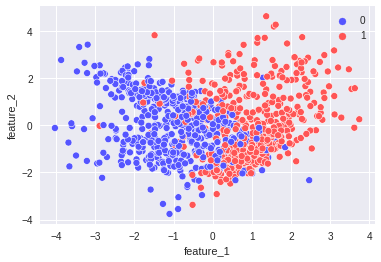

In [171]:
from sklearn import datasets
X_z, y_z = datasets.make_classification(
    n_samples=1000, #количество объектов
    n_features=2, #количество признаков
    n_informative=2, #количество информативных признаков
    n_redundant=0, #количество неинформативных признаков
    n_classes=2, #количество классов
    n_clusters_per_class=2, #количество кластеров внутри класса
    random_state=1 #генератор случайных чисел
)
X_z = pd.DataFrame(X_z, columns=['feature_1', 'feature_2'])
y_z = pd.Series(y_z)
sns.scatterplot(x=X_z['feature_1'], y=X_z['feature_2'], hue=y_z, palette='seismic');

4.3 - Ответ

In [174]:
X_train_z, X_valid_z, y_train_z, y_valid_z = model_selection.train_test_split(X_z, y_z, test_size=0.3, random_state=42)
clf_z = tree.DecisionTreeClassifier(max_depth=10)
clf_z = clf_z.fit(X_train_z, y_train_z)
y_train_pred_z = clf_z.predict(X_train_z)
y_valid_pred_z = clf_z.predict(X_valid_z)
print('Train accuracy: {:.2f}'.format(metrics.accuracy_score(y_train_z, y_train_pred_z)))
print('Valid accuracy: {:.2f}'.format(metrics.accuracy_score(y_valid_z, y_valid_pred_z)))

Train accuracy: 0.98
Valid accuracy: 0.82


### Задание 4.4 (на самопроверку)

Воспользуйтесь функцией plot_probabilities_2d() и постройте разделяющую поверхность обученного дерева решений.

Передайте в её аргументы матрицу наблюдений X, вектор ответов y и обученное в задании 4.3 дерево решений.

Является ли ваша модель переобученной?

/home/mike/anaconda3/envs/sf/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


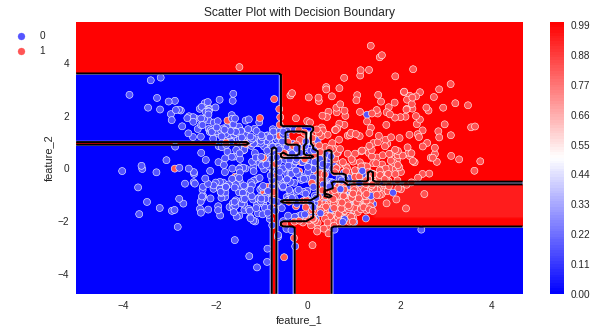

In [178]:
plot_probabilities_2d(X_z, y_z, clf_z)

## МЕТОДЫ БОРЬБЫ С ПЕРЕОБУЧЕНИЕМ

1. УМЕНЬШЕНИЕ СЛОЖНОСТИ МОДЕЛИ

    1.1. Для линейной (логистической) регрессии - понижение степени полинома.

    1.2. Для деревьев решений — уменьшение их глубины (max_depth) и/или увеличение количества объектов, при которых вершина дерева превращается в лист (min_samples_leaf. К примеру: (max_depth=3, min_samples_leaf=5).

    1.3. Для случайного леса — «стрижка» деревьев (max_depth и min_samples_leaf) и уменьшение количества признаков, на которых обучается каждое дерево (max_features)

2. РЕГУЛЯРИЗАЦИЯ

С помощью добавления штрафа в функцию потерь мы намеренно пытаемся увеличить смещение модели, чтобы уменьшить разброс.

3. МАНИПУЛЯЦИИ С ДАННЫМИ

    3.1. Увеличивать набор данных можно за счёт проведения новых экспериментов и сбора новой информации.

    3.2. Уменьшать набор данных можно за счёт удаления выбросов и аномалий из обучающего набора данных, из-за которых отчасти и происходит переобучение модели.

In [179]:
# Посмотрим на текущую глубину дерева:

print('Current depth:', model_bad.get_depth())

Current depth: 27


In [180]:
# Пусть максимальная глубина дерева будет равна 7.

#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #ограничиваем глубину дерева
    random_state=42, #генератор случайных чисел
    class_weight='balanced' #веса классов
)
 
#Создаём объект кросс-валидатора k-fold со стратификацией
skf = model_selection.StratifiedKFold(n_splits=5)
 
#Считаем метрики на кросс-валидации k-fold со стратификацией
cv_metrics = model_selection.cross_validate(
    estimator=model, #модель
    X=X, #матрица наблюдений X
    y=y, #вектор ответов y
    cv=skf, #кросс-валидатор
    scoring='f1', #метрика
    return_train_score=True #подсчёт метрики на тренировочных фолдах
)
 
print('Train k-fold mean f1: {:.2f}'.format(np.mean(cv_metrics['train_score'])))
print('Valid k-fold mean f1: {:.2f}'.format(np.mean(cv_metrics['test_score'])))

Train k-fold mean f1: 0.75
Valid k-fold mean f1: 0.66


Попробуем добавить ещё одно ограничение к нашему дереву: увеличим количество объектов, которых достаточно для образования листа дерева (min_samples_leaf). По умолчанию этот параметр равен 1. 

In [181]:
#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #ограничиваем глубину дерева
    min_samples_leaf=5, #увеличиваем количество объектов в листе
    random_state=42, #генератор случайных чисел
    class_weight='balanced' #веса классов
)
 
#Создаём объект кросс-валидатора k-fold со стратификацией
skf = model_selection.StratifiedKFold(n_splits=5)
 
#Считаем метрики на кросс-валидации k-fold со стратификацией
cv_metrics = model_selection.cross_validate(
    estimator=model, #модель
    X=X, #матрица наблюдений X
    y=y, #вектор ответов y
    cv=skf, #кросс-валидатор
    scoring='f1', #метрика
    return_train_score=True #подсчёт метрики на тренировочных фолдах
)
 
print('Train k-fold mean f1: {:.2f}'.format(np.mean(cv_metrics['train_score'])))
print('Valid k-fold mean f1: {:.2f}'.format(np.mean(cv_metrics['test_score'])))

Train k-fold mean f1: 0.74
Valid k-fold mean f1: 0.66


### Задание 4.6

Обучите модель дерева решений с глубиной 3 (остальные параметры оставьте по умолчанию) для решения задачи классификации на тренировочной выборке.

Сделайте предсказания для тренировочной и валидационной выборок и рассчитайте метрику accuracy.

В качестве ответа укажите значение метрики accuracy на тренировочной и валидационной выборках.

Train accuracy: 0.88
Valid accuracy: 0.85


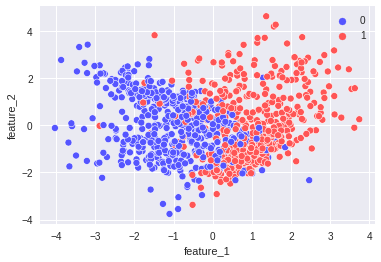

In [183]:
from sklearn import datasets
X_z, y_z = datasets.make_classification(
    n_samples=1000, #количество объектов
    n_features=2, #количество признаков
    n_informative=2, #количество информативных признаков
    n_redundant=0, #количество неинформативных признаков
    n_classes=2, #количество классов
    n_clusters_per_class=2, #количество кластеров внутри класса
    random_state=1 #генератор случайных чисел
)
X_z = pd.DataFrame(X_z, columns=['feature_1', 'feature_2'])
y_z = pd.Series(y_z)
sns.scatterplot(x=X_z['feature_1'], y=X_z['feature_2'], hue=y_z, palette='seismic');
X_train_z, X_valid_z, y_train_z, y_valid_z = model_selection.train_test_split(X_z, y_z, test_size=0.3, random_state=42)
clf_z = tree.DecisionTreeClassifier(max_depth=3)
clf_z = clf_z.fit(X_train_z, y_train_z)
y_train_pred_z = clf_z.predict(X_train_z)
y_valid_pred_z = clf_z.predict(X_valid_z)
print('Train accuracy: {:.2f}'.format(metrics.accuracy_score(y_train_z, y_train_pred_z)))
print('Valid accuracy: {:.2f}'.format(metrics.accuracy_score(y_valid_z, y_valid_pred_z)))

/home/mike/anaconda3/envs/sf/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


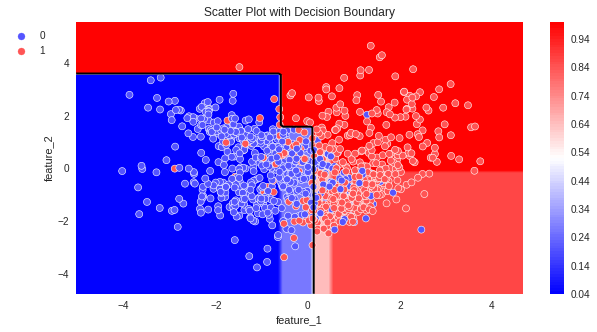

In [185]:
# ЗАДАНИЕ 4.7

plot_probabilities_2d(X_z, y_z, clf_z)

## КРИВАЯ ОБУЧЕНИЯ

Кривая обучения (learning curve) — это график зависимости некоторой метрики на обучающем (валидационном) наборе данных от количества объектов, которые участвуют в обучении модели.

Благодаря этому мы можем найти такой размер данных, начиная с которого обогащение набора данных новыми наблюдениями не приносит значительного эффекта.

Основные параметры функции learning_curve():
- estimator — модель, качество которой будет проверяться.
- X — матрица наблюдений.
- y — вектор-столбец правильных ответов.
- train_sizes — относительное (долевое) или абсолютное количество обучающих примеров, которые будут использоваться для создания кривой обучения. Если dtype имеет значение float, он рассматривается как часть максимального размера обучающего набора (который определяется выбранным методом проверки), т.е. он должен быть в пределах (0, 1]. По умолчанию используется список [0.1, 0.325, 0.55, 0.775, 1.0], т.е. для построения кривой обучения используется пять точек. Первая точка строится по 10 % наблюдений из обучающего набора, вторая точка — по 32.5 % и т.д. до 100%.
- cv — кросс-валидатор из библиотеки sklearn (например, KFold) или количество фолдов, на которые необходимо разбить выборку. По умолчанию используется кросс-валидация k-fold на пяти фолдах.
- scoring — название метрики в виде строки либо функция для её вычисления.

Если передать функции все необходимые параметры, она вернёт три массива:
- Список из размеров тренировочного набора (ось абсцисс кривой обучения).
- Матрица из метрик, полученных при разных размерах тренировочного набора во время кросс-валидации на тренировочных фолдах. В строках этой таблицы указаны списки метрик, соответствующие каждому размеру тренировочного набора данных, а внутри списков находятся сами метрики на кросс-валидации.
- Матрица из метрик, полученных при разных размерах тренировочного набора во время кросс-валидации на валидационных фолдах.

Код для вычисления координат:

In [187]:
#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #максимальная глубина
    min_samples_leaf=5, #минимальное число объектов в листе
    class_weight='balanced', 
    random_state=42, #генератор случайных чисел 
)
 
#Создаём объект кросс-валидатора k-fold со стратификацией
skf = model_selection.StratifiedKFold(n_splits=5)
 
#Вычисляем координаты для построения кривой обучения
train_sizes, train_scores, valid_scores = model_selection.learning_curve(
    estimator = model, #модель
    X = X, #матрица наблюдений X
    y = y, #вектор ответов y
    cv = skf, #кросс-валидатор
    scoring = 'f1' #метрика
)
print('Train sizes: \n', train_sizes)
print('Train scores: \n', train_scores)
print('Valid scores: \n', valid_scores)

Train sizes: 
 [ 262  851 1441 2030 2620]
Train scores: 
 [[0.8        0.72727273 0.72727273 0.72727273 0.72727273]
 [0.76156584 0.82522523 0.8757764  0.8757764  0.8757764 ]
 [0.78546099 0.80108011 0.78497653 0.78183613 0.78183613]
 [0.75440806 0.74526573 0.72822528 0.76443265 0.75997384]
 [0.73336393 0.75992939 0.72322275 0.74051593 0.76085963]]
Valid scores: 
 [[0.62222222 0.2228739  0.18128655 0.25329815 0.28486647]
 [0.64528302 0.4978903  0.46031746 0.53831776 0.56928839]
 [0.59622642 0.60687023 0.60805861 0.56624319 0.60820896]
 [0.60903733 0.68641115 0.63859649 0.59344894 0.67407407]
 [0.61981982 0.6797153  0.66294227 0.61689587 0.71719039]]


Для того чтобы вычислить среднюю кросс-валидационную метрику на каждом из наборов данных, необходимо рассчитать среднее по столбцам матриц train_scores и valid_scores:

In [188]:
train_scores_mean = np.mean(train_scores, axis=1)
valid_scores_mean = np.mean(valid_scores, axis=1)
 
print('Train k-fold f1 scores',  train_scores_mean)
print('Valid k-fold f1 scores',  valid_scores_mean)

Train k-fold f1 scores [0.74181818 0.84282405 0.78703798 0.75046111 0.74357833]
Valid k-fold f1 scores [0.31290946 0.54221938 0.59712148 0.6403136  0.65931273]


Теперь можно построить графики кривых обучения:

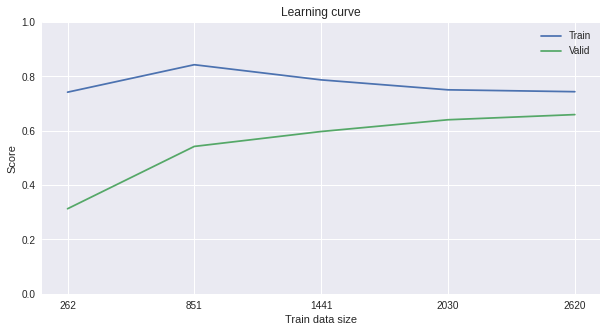

In [189]:
#Визуализируем кривую обучения
fig, ax = plt.subplots(figsize=(10, 5)) #фигура + координатная плоскость
#Строим кривую обучения по метрикам на тренировочных фолдах
ax.plot(train_sizes, train_scores_mean, label='Train')
#Строим кривую обучения по метрикам на валидационных фолдах
ax.plot(train_sizes, valid_scores_mean, label='Valid')
#Даём название графику и подписи осям
ax.set_title('Learning curve')
ax.set_xlabel('Train data size')
ax.set_ylabel('Score')
#Устанавливаем отметки по оси абсцисс
ax.xaxis.set_ticks(train_sizes)
#Устаналиваем диапазон оси ординат
ax.set_ylim(0, 1)
#Отображаем легенду
ax.legend();

### Функция для отрисовки кривых обучения plot_learning_curve(). Аргументы: модель, набор данных (X, y), кросс-валидатор, метрика, координатная плоскость matplotlib, на которой будет строиться график, и подпись графика:

In [191]:
# plot_learning_curve

def plot_learning_curve(model, X, y, cv, scoring="f1", ax=None, title=""):
    # Вычисляем координаты для построения кривой обучения
    train_sizes, train_scores, valid_scores = model_selection.learning_curve(
        estimator=model,  # модель
        X=X,  # матрица наблюдений X
        y=y,  # вектор ответов y
        cv=cv,  # кросс-валидатор
        scoring="f1",  # метрика
    )
    # Вычисляем среднее значение по фолдам для каждого набора данных
    train_scores_mean = np.mean(train_scores, axis=1)
    valid_scores_mean = np.mean(valid_scores, axis=1)
    # Если координатной плоскости не было передано, создаём новую
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 4))  # фигура + координатная плоскость
    # Строим кривую обучения по метрикам на тренировочных фолдах
    ax.plot(train_sizes, train_scores_mean, label="Train")
    # Строим кривую обучения по метрикам на валидационных фолдах
    ax.plot(train_sizes, valid_scores_mean, label="Valid")
    # Даём название графику и подписи осям
    ax.set_title("Learning curve: {}".format(title))
    ax.set_xlabel("Train data size")
    ax.set_ylabel("Score")
    # Устанавливаем отметки по оси абсцисс
    ax.xaxis.set_ticks(train_sizes)
    # Устанавливаем диапазон оси ординат
    ax.set_ylim(0, 1)
    # Отображаем легенду
    ax.legend()

Построим кривые обучения для нескольких моделей. Будем использовать следующие модели:
- логистическую регрессию,
- дерево решений с ограниченной максимальной глубиной и количеством объектов в листе,
- дерево решений без ограничений.

Создадим список, в котором будем хранить эти модели:

In [192]:
#Создаём список из моделей
models = [
    linear_model.LogisticRegression(
        max_iter=1000, #количество итераций на сходимость
        random_state=42, #генератор случайных чисел
        class_weight='balanced' #веса классов
    ),
    tree.DecisionTreeClassifier(
        criterion='entropy', #критерий информативности
        max_depth=7, #максимальная глубина
        min_samples_leaf=5, #минимальное число объектов в листе
        random_state=42, #генератор случайных чисел 
        class_weight='balanced' #веса классов
    ),
    tree.DecisionTreeClassifier(
        criterion='entropy', #критерий информативности
        random_state=42, #генератор случайных чисел 
        class_weight='balanced' #веса классов
    ),
]

Построим кривые обучения для каждой из моделей. Для этого создадим k-fold-кросс-валидатор со стратификацией на пять фолдов. Создадим фигуру с тремя координатными плоскостями. Реализуем цикл по составленному списку (предыдущий шаг) из моделей и их индексам (они нам понадобятся для отображения на соответствующих координатных плоскостях). Внутри цикла будем вызывать нашу функцию plot_learning_curve():

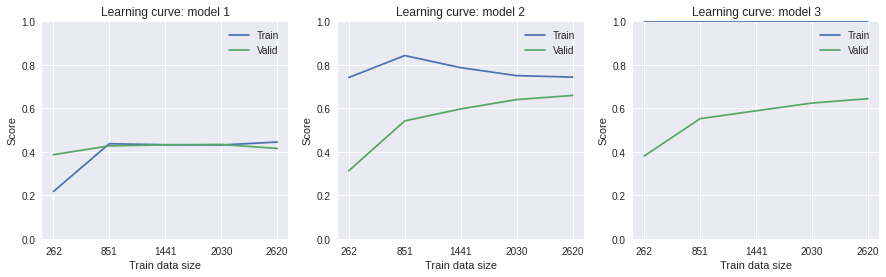

In [193]:
#Создаём объект кросс-валидатора k-fold со стратификацией
skf = model_selection.StratifiedKFold(n_splits=5)
#Визуализируем кривые обучения
fig, axes = plt.subplots(1, 3, figsize=(15, 4)) #фигура + три координатных плоскости
#Создаём цикл по списку моделей и индексам этого списка
for i, model in enumerate(models): #i — текущий индекс, model — текущая модель
    plot_learning_curve(model, X, y, skf, ax=axes[i], title=f'model {i+1}')